# Neural Network Implementation from Scratch

In this notebook, I implement a neural network from scratch using Python and NumPy. The framework consists of several core classes that together handle the forward pass, backward pass, and training using stochastic gradient descent (SGD).

---

## 🔧 `Layer` Class

This class represents a fully connected layer in the neural network. It includes the following key components:

- **`setup(input_size)`**: Initializes the weights and biases for the layer based on the input size.
- **`forward(input)`**: Computes the output of the layer by applying the weighted sum and the chosen activation function.
- **`backward(output_gradient, learning_rate)`**: Computes the gradients of the loss with respect to the layer’s parameters and updates the weights and biases accordingly.

The backward function propagates the gradient from the current layer to the previous one using the chain rule. Three activation functions are supported:
- ReLU
- Sigmoid
- Tanh

For each activation function, both the function itself and its derivative are implemented.

---

## 📈 `SoftmaxLayer`

This class takes the final output of the last layer (a NumPy array) and applies the softmax transformation to convert raw scores into probability distributions.

---

## 🧮 `CrossEntropyLoss`

The `CrossEntropyLoss` class implements the categorical cross-entropy loss, commonly used for classification problems. It has:

- **`forward(predictions, targets)`**: Computes the loss.
- **`backward()`**: Calculates the gradient of the loss with respect to the output of the last layer.

---

## 🧠 `Network` Class

This class defines the overall structure and training process of the neural network. Its key functionalities include:

- **`add(layer)`**: Adds a new layer to the network.
- **`setup()`**: Prepares the network by initializing all layers with the appropriate input/output dimensions.
- **`forward(input, target)`**: Performs a complete forward pass through all layers and computes the loss.
- **`backward(learning_rate)`**: Propagates the gradient backward and updates all parameters.

### 🌀 `SGD` Training

The network includes a method called `SGD` (Stochastic Gradient Descent) for training. It:
- Accepts a batch size and number of epochs.
- Randomly shuffles the data at each epoch.
- Trains the network on small batches for more efficient and generalizable updates.

---

This modular design allows for flexibility in defining different network architectures, activation functions, and training settings.


In [143]:
from typing_extensions import final
class Layer():
    def __init__(self, output_size, activation_function):
        self.input_size = None
        self.output_size = output_size
        self.input = None
        self.z = None  # pre-activation
        self.a = None  # post-activation (activated output)
        self.weights = None
        self.bias = None

        if activation_function == "relu":
            self.activation_function = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation_function == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation_function == "tanh":
            self.activation_function = self.tanh
            self.activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function")

    def setup(self, input_size):
        self.input_size = input_size
        self.weights = np.random.randn(self.input_size, self.output_size) * np.sqrt(2 / self.input_size)
        self.bias = np.zeros((1, self.output_size))

    def forward(self, input):
        self.input = input
        self.z = np.dot(self.input, self.weights) + self.bias
        self.a = self.activation_function(self.z)
        return self.a

    def backward(self, output_gradient, learning_rate):
        dz = output_gradient * self.activation_derivative(self.z)

        dw = np.dot(self.input.T, dz)
        db = np.sum(dz, axis=0, keepdims=True)
        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db
        return np.dot(dz, self.weights.T)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

class softmax_layer():
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        exp_input = np.exp(input - np.max(input, axis=1, keepdims=True))  # for stability
        self.output = exp_input / np.sum(exp_input, axis=1, keepdims=True)
        return self.output
class Cross_Entropy_layer():
    def __init__(self):
        self.target = None
        self.input = None
        self.loss = None

    def forward(self, input, target):
        self.input = np.clip(input, 1e-15, 1 - 1e-15)  # Avoid log(0)
        self.target = target
        self.loss = -np.sum(self.target * np.log(self.input)) / self.input.shape[0]
        return self.loss

    def backward(self):
        return (self.input - self.target) / self.input.shape[0]
class Network():

  def __init__(self , input_size ):
    self.layers = []
    self.in_dim =  input_size
    self.out_dim = None
    self.soft_max_layer = None
    self.cross_entropy = None
    self.input = None
    self.target = None
    self.number_of_Learnabale_param = 0

  def add(self, layer):
    self.layers.append(layer)

  def setup(self ):

    self.out_dim = self.layers[-1].output_size
    self.layers[0].setup(self.in_dim)
    input = self.in_dim
    for i in range(1, len(self.layers)):
      self.layers[i].setup(self.layers[i-1].output_size)
      self.number_of_Learnabale_param += input * self.layers[i].output_size + self.layers[i].output_size
      input = self.layers[i].output_size
    self.soft_max_layer = softmax_layer()
    self.cross_entropy = Cross_Entropy_layer()

  def number_of_Learnabale_param(self):

    return self.number_of_Learnabale_param


  def forward(self, input, target):
    self.input = input
    self.target = target
    current_output = self.layers[0].forward(self.input)
    for i in range(1, len(self.layers)):
        current_output = self.layers[i].forward(current_output)

    current_output = self.soft_max_layer.forward(current_output)
    self.cross_entropy.forward(current_output, self.target)
    return current_output , self.cross_entropy.loss


  def backward(self, learning_rate):
    output_gradient = self.cross_entropy.backward()
    for i in range(len(self.layers) - 1, -1, -1):
        output_gradient = self.layers[i].backward(output_gradient, learning_rate)


  def SGD(self, X, y, epochs=10, learning_rate=0.01, batch_size=1):
    num_samples = X.shape[0]
    loss_list = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
        final_loss = 0
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_batch = X[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]

            _, loss = self.forward(X_batch, y_batch)
            self.backward(learning_rate)
            final_loss += loss
        loss_list.append(final_loss)
        print(f"Loss after epoch {epoch + 1}: {final_loss:.4f}")
    return loss_list

  def Test(self , X_test , y_test):
      correct = 0
      for i in range(len(X_test)):
        output , output1 = self.forward(X_test[i] , y_test)
        if np.argmax(output) == np.argmax(y_test[i]):
          correct += 1
      print("Accuracy: ", correct / len(X_test))
      return correct / len(X_test)


In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [164]:
data = pd.read_csv('/content/breast-cancer-diagnostic.shuf.lrn.csv')


y_train =  pd.DataFrame( data['class'])
X_train =  pd.DataFrame( data.drop(['class' , 'ID'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)


# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

encoder = OneHotEncoder(sparse_output=False, dtype=int)
# Fit and transform
y_train = encoder.fit_transform(y_train)


## Architecture of the Neural Network

![Network Architecture](/content/network.png)
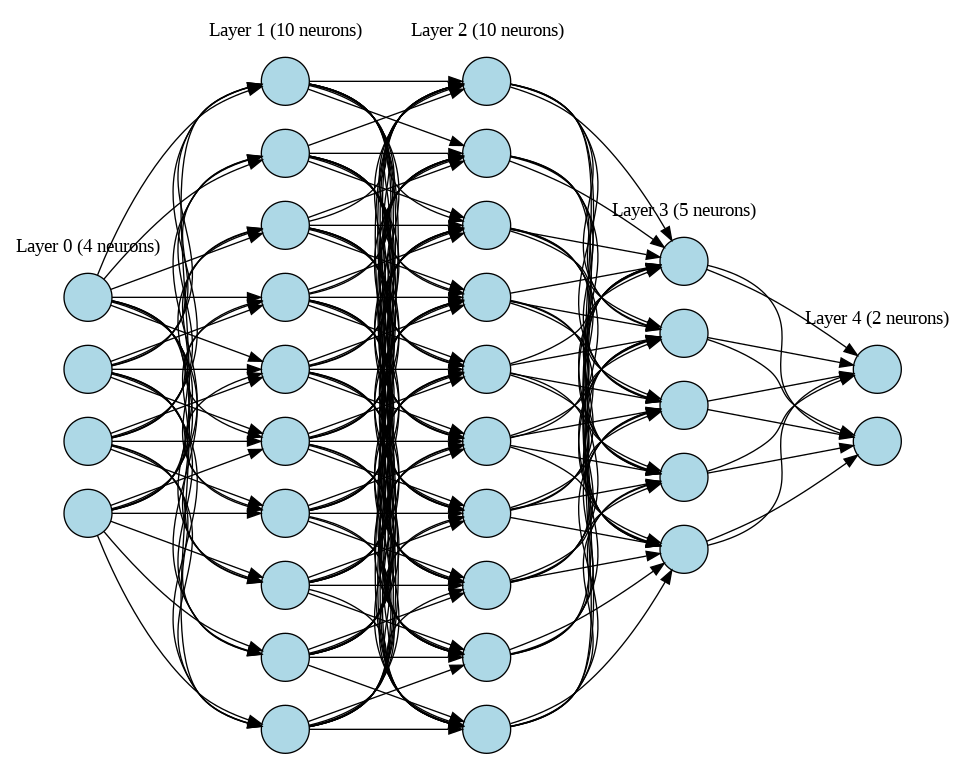

![]("content/network.png)

In [165]:
# Convert y_train to a numpy array before training


net = Network(input_size=30)
net.add(Layer(10, "relu"))
net.add(Layer(10, "relu"))
net.add(Layer(5, "relu"))
net.add(Layer(2, "sigmoid"))
net.setup()

print(net.number_of_Learnabale_param)
# Use the numpy array version of y_train for training
loss_list = net.SGD(X_train, y_train, epochs=50, learning_rate=0.01, batch_size=1)

377
Epoch 1/50
Loss after epoch 1: 163.0529
Epoch 2/50
Loss after epoch 2: 138.4606
Epoch 3/50
Loss after epoch 3: 115.2111
Epoch 4/50
Loss after epoch 4: 101.2385
Epoch 5/50
Loss after epoch 5: 94.1764
Epoch 6/50
Loss after epoch 6: 90.9372
Epoch 7/50
Loss after epoch 7: 89.3392
Epoch 8/50
Loss after epoch 8: 88.3160
Epoch 9/50
Loss after epoch 9: 87.5010
Epoch 10/50
Loss after epoch 10: 86.9592
Epoch 11/50
Loss after epoch 11: 86.2635
Epoch 12/50
Loss after epoch 12: 85.6309
Epoch 13/50
Loss after epoch 13: 85.2575
Epoch 14/50
Loss after epoch 14: 85.0611
Epoch 15/50
Loss after epoch 15: 84.8231
Epoch 16/50
Loss after epoch 16: 84.6102
Epoch 17/50
Loss after epoch 17: 84.4510
Epoch 18/50
Loss after epoch 18: 84.2931
Epoch 19/50
Loss after epoch 19: 84.1693
Epoch 20/50
Loss after epoch 20: 84.0455
Epoch 21/50
Loss after epoch 21: 83.9627
Epoch 22/50
Loss after epoch 22: 83.8718
Epoch 23/50
Loss after epoch 23: 83.6943
Epoch 24/50
Loss after epoch 24: 83.3216
Epoch 25/50
Loss after epo

In [166]:
y_test = encoder.transform(y_test)
net.Test(X_test, y_test)

Accuracy:  0.9655172413793104


0.9655172413793104

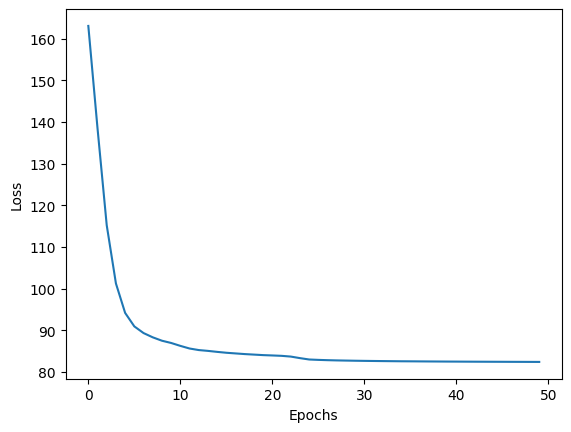

In [167]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Second Dataset


In [149]:


import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Assuming the classes Layer, softmax_layer, Cross_Entropy_layer, and Network are defined as above
X_train = pd.read_csv("/content/X_coupon_train.csv", header=None)
y_train = pd.read_csv("/content/y_coupon_train.csv", header=None) # Read y_train without header as well

X_test = pd.read_csv("/content/X_coupon_test.csv" , header = None)
y_test = pd.read_csv("/content/y_coupon_test.csv", header=None) # Read y_test without header as well

# Rename the single column in y_train and y_test to a consistent name
y_train.columns = ['target']
y_test.columns = ['target']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

encoder = OneHotEncoder(sparse_output=False, dtype=int)
# Fit and transform
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [118]:
X_train.shape

(10088, 22)

Hier is the Network
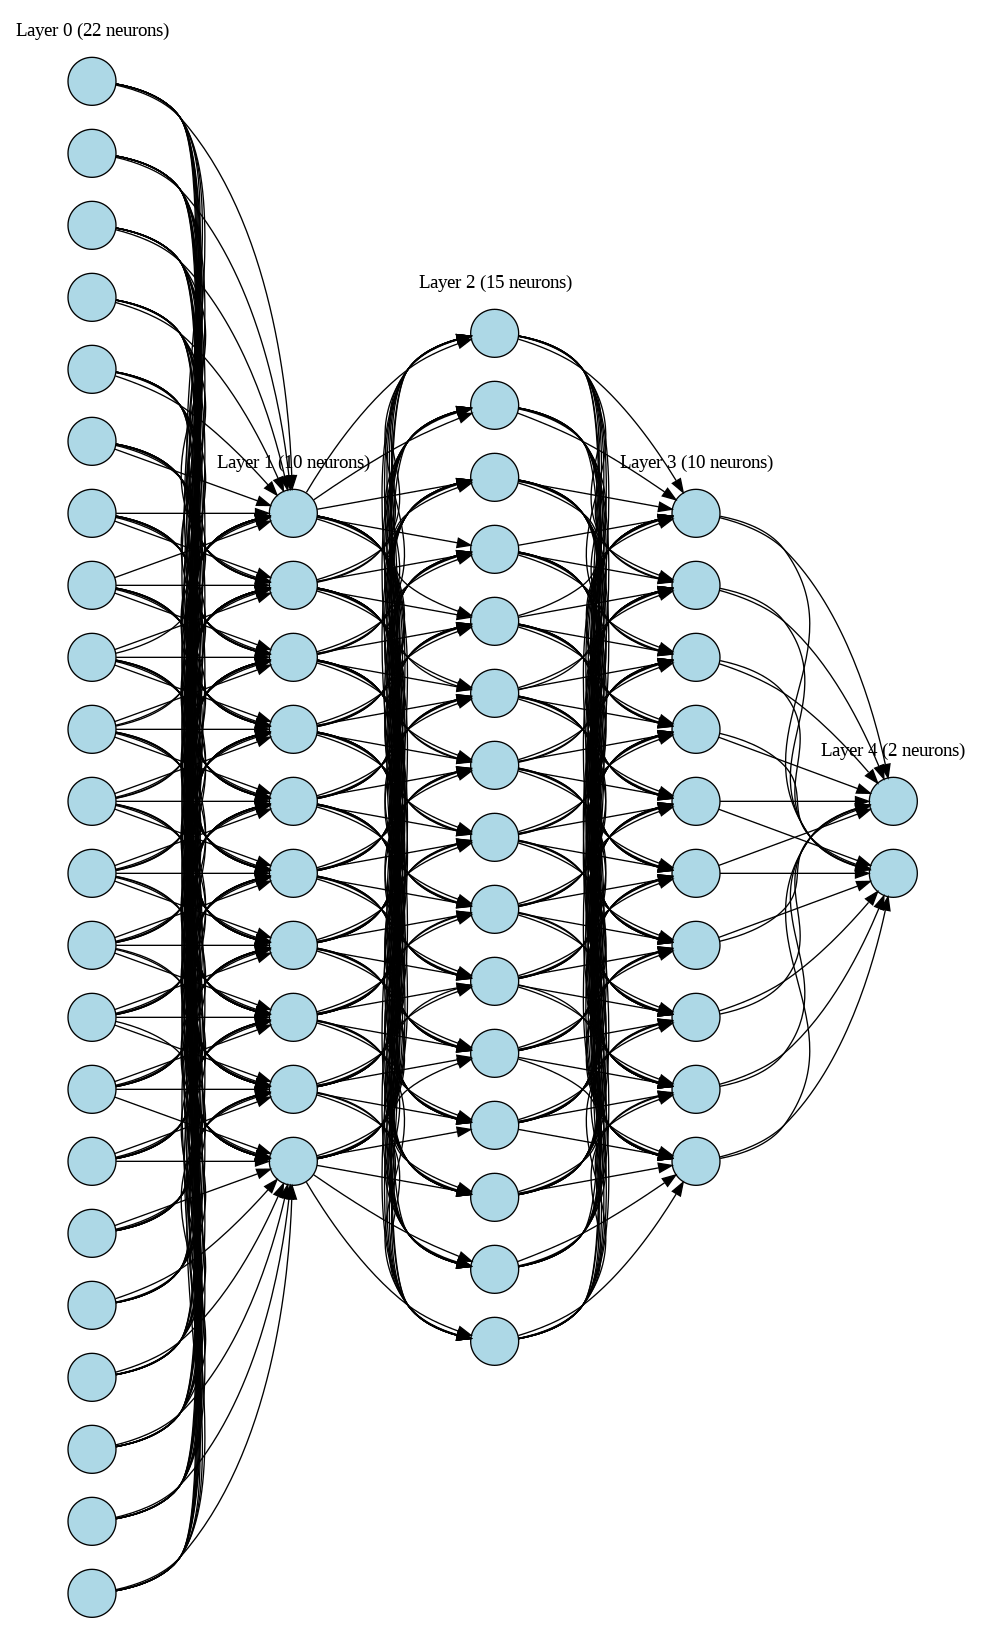

In [150]:


net = Network(input_size=22)
net.add(Layer(10, "relu"))
net.add(Layer(15, "tanh"))
net.add(Layer(10, "relu"))
net.add(Layer(2, "relu"))
net.setup()

print(net.number_of_Learnabale_param)
# Use the numpy array version of y_train for training
# net.SGD(X_train, y_train, epochs=100 , learning_rate=0.1, batch_size=1)
# Use the numpy array version of X_train and y_train for training
loss_list = net.SGD(X_train, y_train, epochs=50 , learning_rate=0.01, batch_size=10)

527
Epoch 1/50
Loss after epoch 1: 683.6783
Epoch 2/50
Loss after epoch 2: 646.6145
Epoch 3/50
Loss after epoch 3: 614.8795
Epoch 4/50
Loss after epoch 4: 600.3615
Epoch 5/50
Loss after epoch 5: 592.1186
Epoch 6/50
Loss after epoch 6: 586.6059
Epoch 7/50
Loss after epoch 7: 582.3763
Epoch 8/50
Loss after epoch 8: 580.3333
Epoch 9/50
Loss after epoch 9: 577.5392
Epoch 10/50
Loss after epoch 10: 574.8387
Epoch 11/50
Loss after epoch 11: 574.0605
Epoch 12/50
Loss after epoch 12: 572.3637
Epoch 13/50
Loss after epoch 13: 571.2560
Epoch 14/50
Loss after epoch 14: 569.3138
Epoch 15/50
Loss after epoch 15: 568.1032
Epoch 16/50
Loss after epoch 16: 568.0347
Epoch 17/50
Loss after epoch 17: 566.7066
Epoch 18/50
Loss after epoch 18: 566.6386
Epoch 19/50
Loss after epoch 19: 565.9037
Epoch 20/50
Loss after epoch 20: 564.2617
Epoch 21/50
Loss after epoch 21: 563.1939
Epoch 22/50
Loss after epoch 22: 563.2778
Epoch 23/50
Loss after epoch 23: 562.7866
Epoch 24/50
Loss after epoch 24: 562.2753
Epoch 

In [151]:
net.Test(X_test, y_test)

Accuracy:  0.7069785884218874


0.7069785884218874

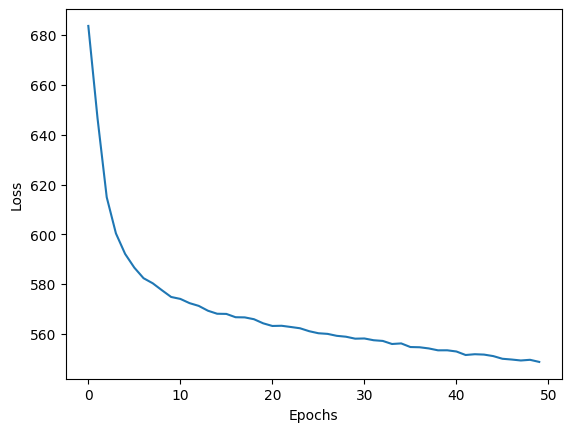

In [152]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Appendix

The function below used to show the GUI of the arcitecture of the neural network.

In [141]:
from graphviz import Digraph

def visualize_network(layer_sizes):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR')  # Left to Right layout

    # Create nodes for each layer
    for l, size in enumerate(layer_sizes):
        with dot.subgraph(name=f'cluster_{l}') as c:
            c.attr(color='white')
            for n in range(size):
                c.node(f'L{l}_N{n}', shape='circle', label='', style='filled', fillcolor='lightblue')
            c.attr(label=f'Layer {l} ({size} neurons)')

    # Connect nodes
    for l in range(len(layer_sizes) - 1):
        for n1 in range(layer_sizes[l]):
            for n2 in range(layer_sizes[l+1]):
                dot.edge(f'L{l}_N{n1}', f'L{l+1}_N{n2}')

    return dot


In [142]:
layer_sizes = [22,10 , 15, 10,2]  # [input, hidden1, hidden2, output]
visualize_network(layer_sizes).render('network', view=True)


'network.png'